# Analysing DNA Sequences and Finding Protein-Coding Regions

Gene: Human Insulin

## Downloading Sequence Data from Entrez Database

In [ ]:
# Library
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord

In [ ]:
# Always provide your email when using NCBI services
Entrez.email = "<your_email@example.com"

In [ ]:
# Fetch the human insulin gene sequence
handle = Entrez.efetch(db="nucleotide", id="NM_000207", rettype="fasta", retmode="text")
record: SeqRecord = SeqIO.read(handle, "fasta")
handle.close()

print(f"Sequence ID: {record.id}")
print(f"Description: {record.description}")
print(f"Length: {len(record.seq)} bp")

Sequence ID: NM_000207.3
Description: NM_000207.3 Homo sapiens insulin (INS), transcript variant 1, mRNA
Length: 465 bp


## Basic Sequence Analysis

In [4]:
record.seq

Seq('AGCCCTCCAGGACAGGCTGCATCAGAAGAGGCCATCAAGCAGATCACTGTCCTT...AGC')

In [ ]:
print(record.seq)

AGCCCTCCAGGACAGGCTGCATCAGAAGAGGCCATCAAGCAGATCACTGTCCTTCTGCCATGGCCCTGTGGATGCGCCTCCTGCCCCTGCTGGCGCTGCTGGCCCTCTGGGGACCTGACCCAGCCGCAGCCTTTGTGAACCAACACCTGTGCGGCTCACACCTGGTGGAAGCTCTCTACCTAGTGTGCGGGGAACGAGGCTTCTTCTACACACCCAAGACCCGCCGGGAGGCAGAGGACCTGCAGGTGGGGCAGGTGGAGCTGGGCGGGGGCCCTGGTGCAGGCAGCCTGCAGCCCTTGGCCCTGGAGGGGTCCCTGCAGAAGCGTGGCATTGTGGAACAATGCTGTACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAGACGCAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGC


### Complement

In [6]:
record.seq.complement()

Seq('TCGGGAGGTCCTGTCCGACGTAGTCTTCTCCGGTAGTTCGTCTAGTGACAGGAA...TCG')

### Reverse Complement

In [7]:
record.seq.reverse_complement()

Seq('GCTGGTTCAAGGGCTTTATTCCATCTCTCTCGGTGCAGGAGGCGGCGGGTGTGG...GCT')

### Nucleotide Count

In [10]:
a_count = record.seq.count('A')
t_count = record.seq.count('T')
g_count = record.seq.count('G')
c_count = record.seq.count('C')

print(f"Nucleotide Composition:")
print(f"A: {a_count} ({a_count / len(record.seq):.2%})")
print(f"T: {t_count} ({t_count / len(record.seq):.2%})")
print(f"G: {g_count} ({g_count / len(record.seq):.2%})")
print(f"C: {c_count} ({c_count / len(record.seq):.2%})")

Nucleotide Composition:
A: 91 (19.57%)
T: 77 (16.56%)
G: 141 (30.32%)
C: 156 (33.55%)


In [11]:
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\shres\AppData\Local\Temp\ipykernel_16076\1269310117.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[a_count, t_count, g_count, c_count], y=['A', 'T', 'G', 'C'], palette="viridis")


<Axes: >

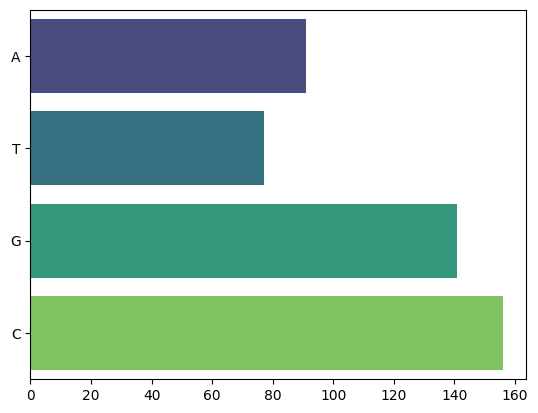

In [21]:
sns.barplot(x=[a_count, t_count, g_count, c_count], y=['A', 'T', 'G', 'C'], palette="viridis")

### Calculate GC Content

In [9]:
from Bio.SeqUtils import gc_fraction

gc_content = gc_fraction(record.seq)

print(f"GC Content: {gc_content:.2%}")

GC Content: 63.87%


## Finding Open Reading Frames (ORFs)

In [23]:
def find_orfs(sequence, min_protein_length=100):
    """Find all ORFs in a DNA sequence"""
    orfs = []

    # Check all three reading frames
    for frame in range(3):
        # Get the sequence for this frame
        seq_frame = sequence[frame:]

        # Translate to protein
        protein = seq_frame.translate(to_stop=False)
        
        # Find all start codons
        start = 0
        while True:
            start = str(protein).find('M', start)
            if start == -1:
                break

            # Find the next stop codon
            stop = start + 1
            while stop < len(protein) and protein[stop] != '*':
                stop += 1

            # If we found a complete ORF
            if stop < len(protein):
                orf_length = stop - start
                if orf_length >= min_protein_length:
                    orfs.append({
                        'frame': frame,
                        'start': frame + start * 3,
                        'stop': frame + stop * 3,
                        'length': orf_length,
                        'protein': str(protein[start:stop])
                    })

            start += 1
            
    return orfs

In [24]:
# Find ORFs
orfs = find_orfs(record.seq, min_protein_length=50)
orfs

c:\Users\shres\Projects\BioPy\.venv\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


[{'frame': 2,
  'start': 59,
  'stop': 389,
  'length': 110,
  'protein': 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'},
 {'frame': 2,
  'start': 71,
  'stop': 389,
  'length': 106,
  'protein': 'MRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'}]

In [28]:
print(f"Found {len(orfs)} ORFs (minimum 50 amino-acids)")
for i, orf in enumerate(orfs[:3], 1):
    print(f"\nORF {i}:")
    print(f"    Frame: {orf['frame']}")
    print(f"    Position: {orf['start']} - {orf['stop']}")
    print(f"    Protein Length: {orf['length']} aa")
    print(f"    Protein Sequence: {orf['protein'][:50]}...")

Found 2 ORFs (minimum 50 amino-acids)

ORF 1:
    Frame: 2
    Position: 59 - 389
    Protein Length: 110 aa
    Protein Sequence: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFY...

ORF 2:
    Frame: 2
    Position: 71 - 389
    Protein Length: 106 aa
    Protein Sequence: MRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKT...
